In [2]:
import torch
import random
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import xgboost as xgb
from torch import optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from concurrent.futures import ThreadPoolExecutor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# set seed and suppress warinings
random.seed(42)
torch.manual_seed(42)
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('colleges_train.csv')
print(df.head())

# preprocess data
y = df['tuition']
x = df.drop(columns=['tuition', 'name', 'state'])
x_columns = x.columns

# Helpful (makes predictions better on average)
for comb in itertools.combinations(x_columns, 2):
    x[comb[0] + '*' + comb[1]] = x[comb[0]] * x[comb[1]]
    x[comb[0] + '/' + comb[1]] = np.where(x[comb[1]] != 0, x[comb[0]] / x[comb[1]], 0)

# Not helpful (makes predictions worse on average)
# for col in x_columns:
#     x['log_' + col] = np.log(x[col] + 1)
#     x['sqrt_' + col] = np.sqrt(x[col])
#     x['exp_' + col] = np.exp(x[col])
#     x['sq_' + col] = x[col] ** 2

n = x.shape[0]
print(f"{n} samples with {x.shape[1]} features")

# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

                             name state  adm_rate  satv25  satv50  satv75  \
0             Sweet Briar College    VA      0.79     540     585     630   
1                   Salem College    NC      0.80     460     520     580   
2                Barry University    FL      0.51     480     515     550   
3  Texas A&M University-Texarkana    TX      0.94     480     530     580   
4           Blue Mountain College    MS      0.96     450     510     570   

   satm25  satm50  satm75  pell_grant_rate  ...  arch_deg  agri_deg  hist_deg  \
0     470     525     580           0.3065  ...       0.0       0.0    0.0385   
1     450     505     560           0.5469  ...       0.0       0.0    0.0455   
2     450     490     530           0.4832  ...       0.0       0.0    0.0000   
3     490     530     570           0.5153  ...       0.0       0.0    0.0377   
4     590     595     600           0.4865  ...       0.0       0.0    0.0692   

   socialsci_deg  health_deg  business_deg  ft_fac

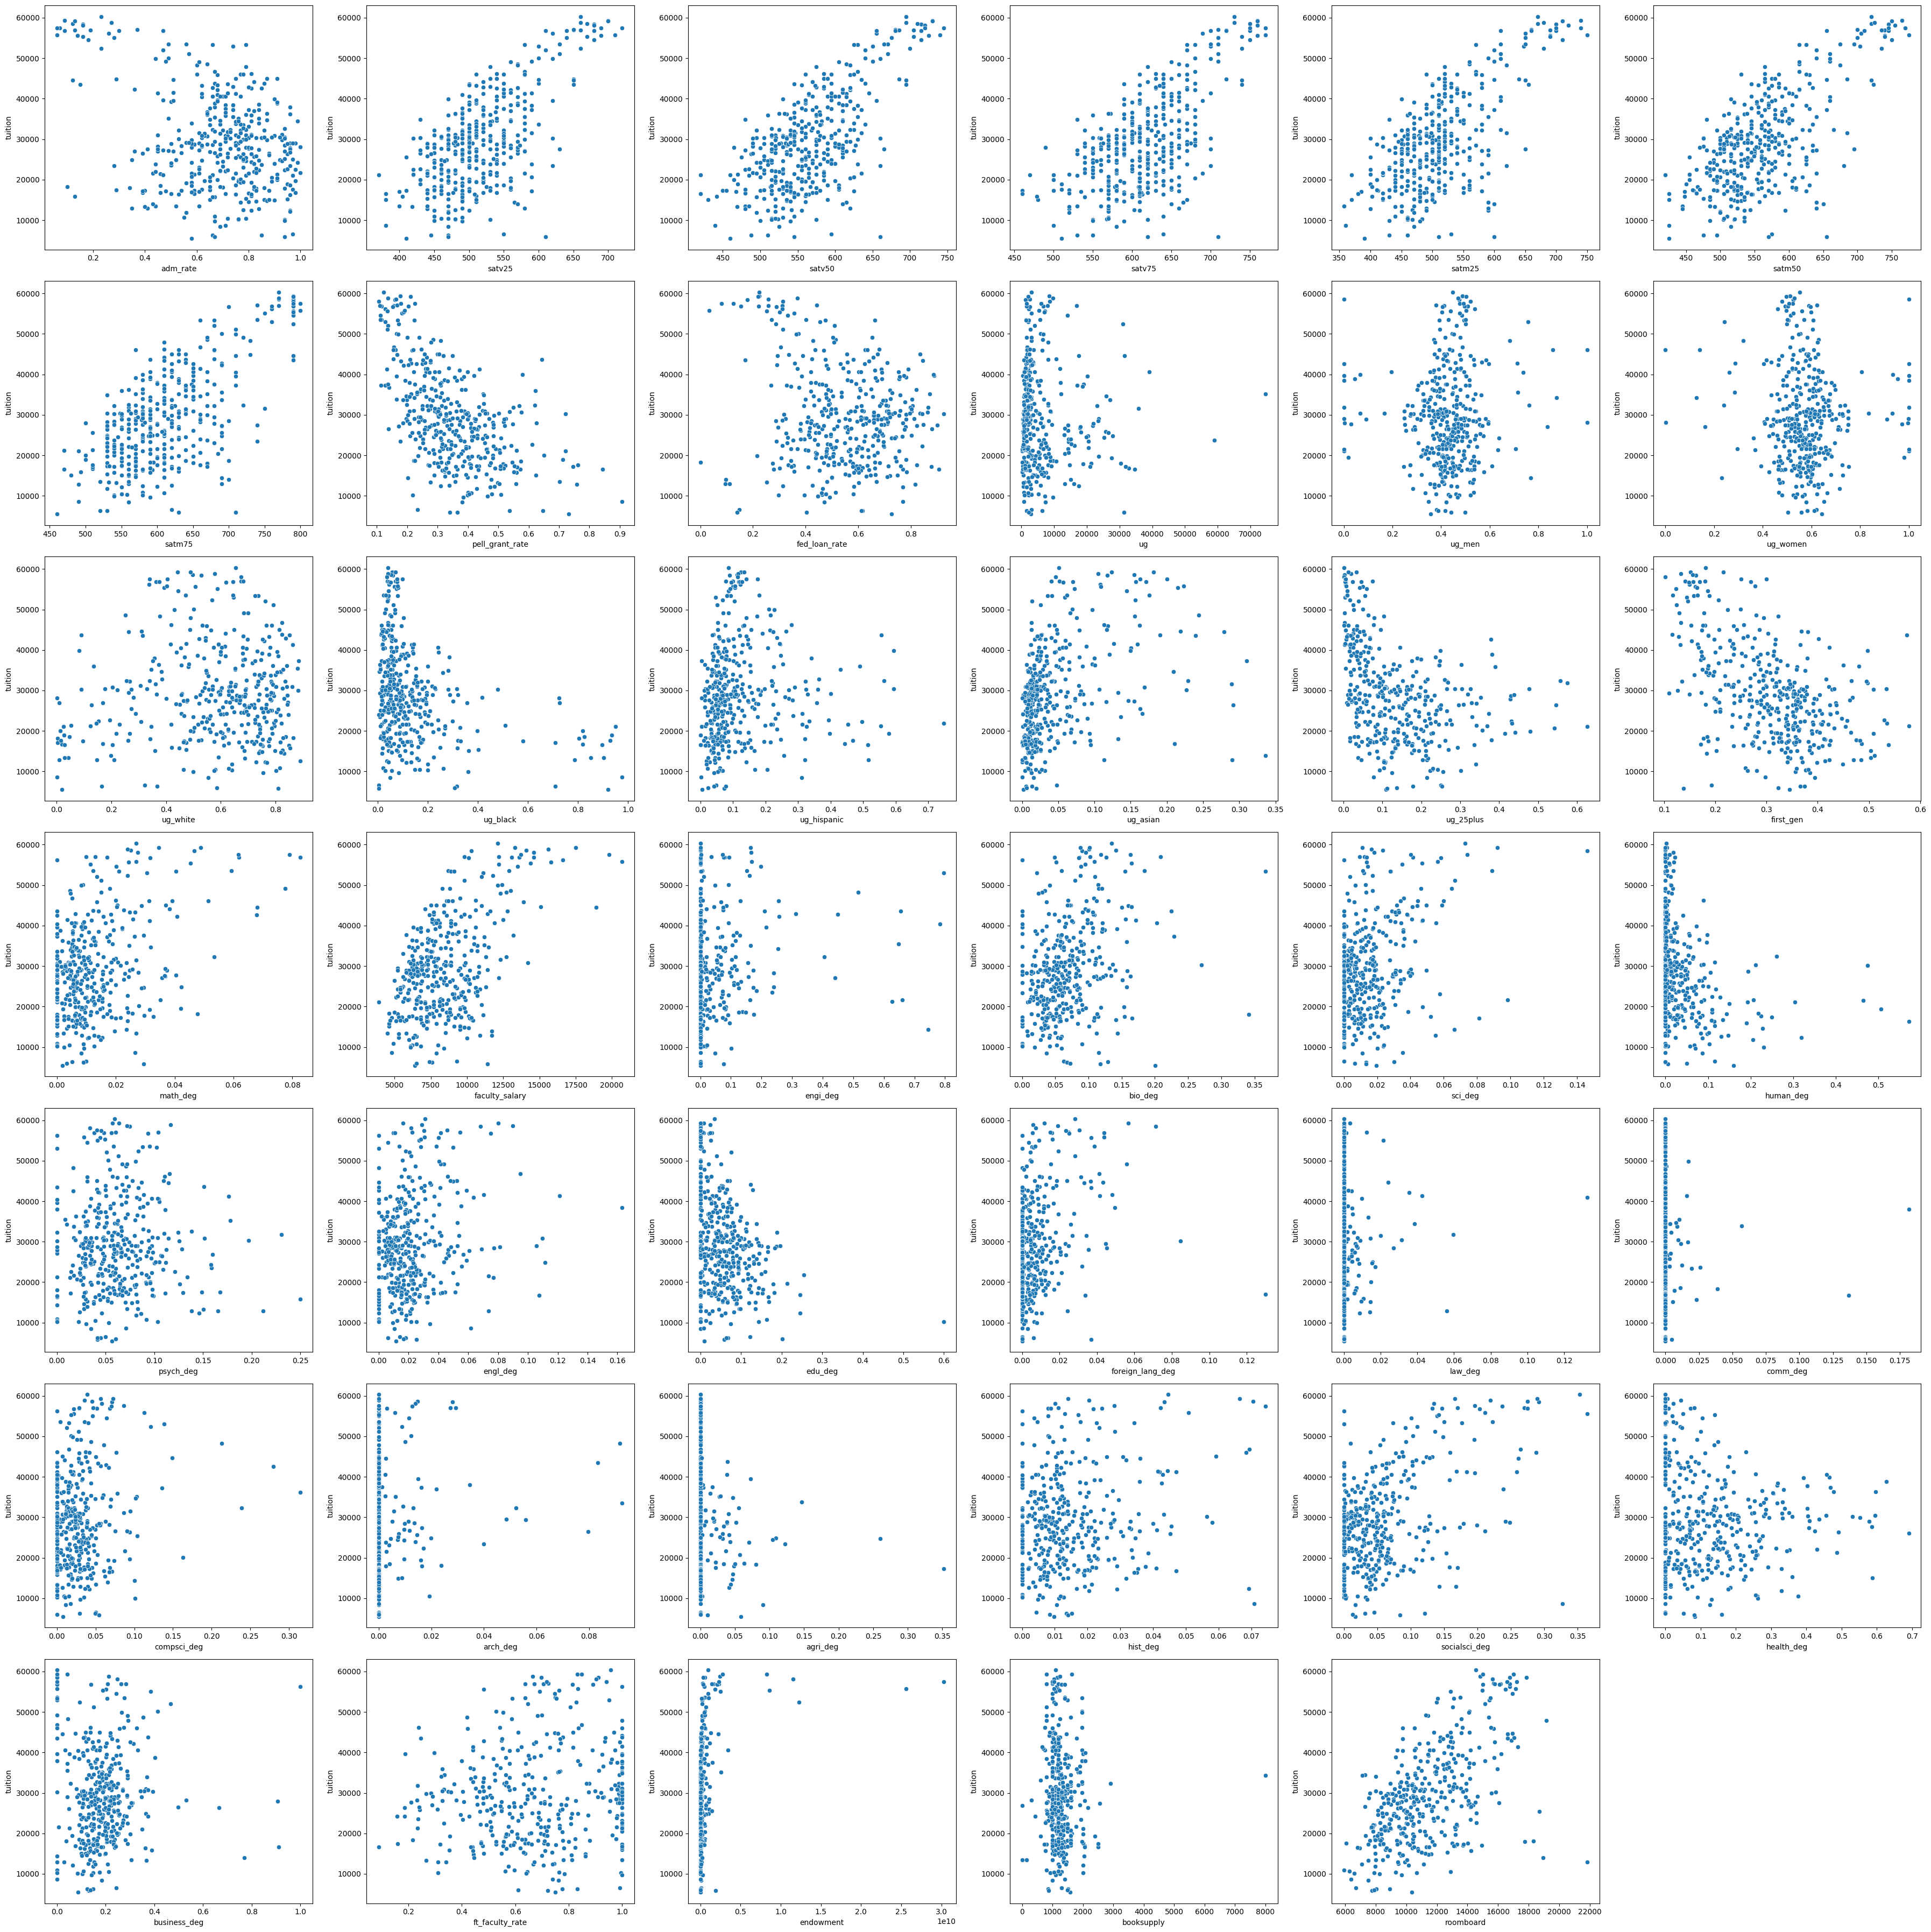

In [ ]:
# Plot scatter plots
plt.figure(figsize=(36, 36))
for feature in x_columns.to_list():
    plt.subplot(7, 6, x_columns.to_list().index(feature) + 1)
    sns.scatterplot(x=x[feature], y=y)
plt.tight_layout()
plt.show()

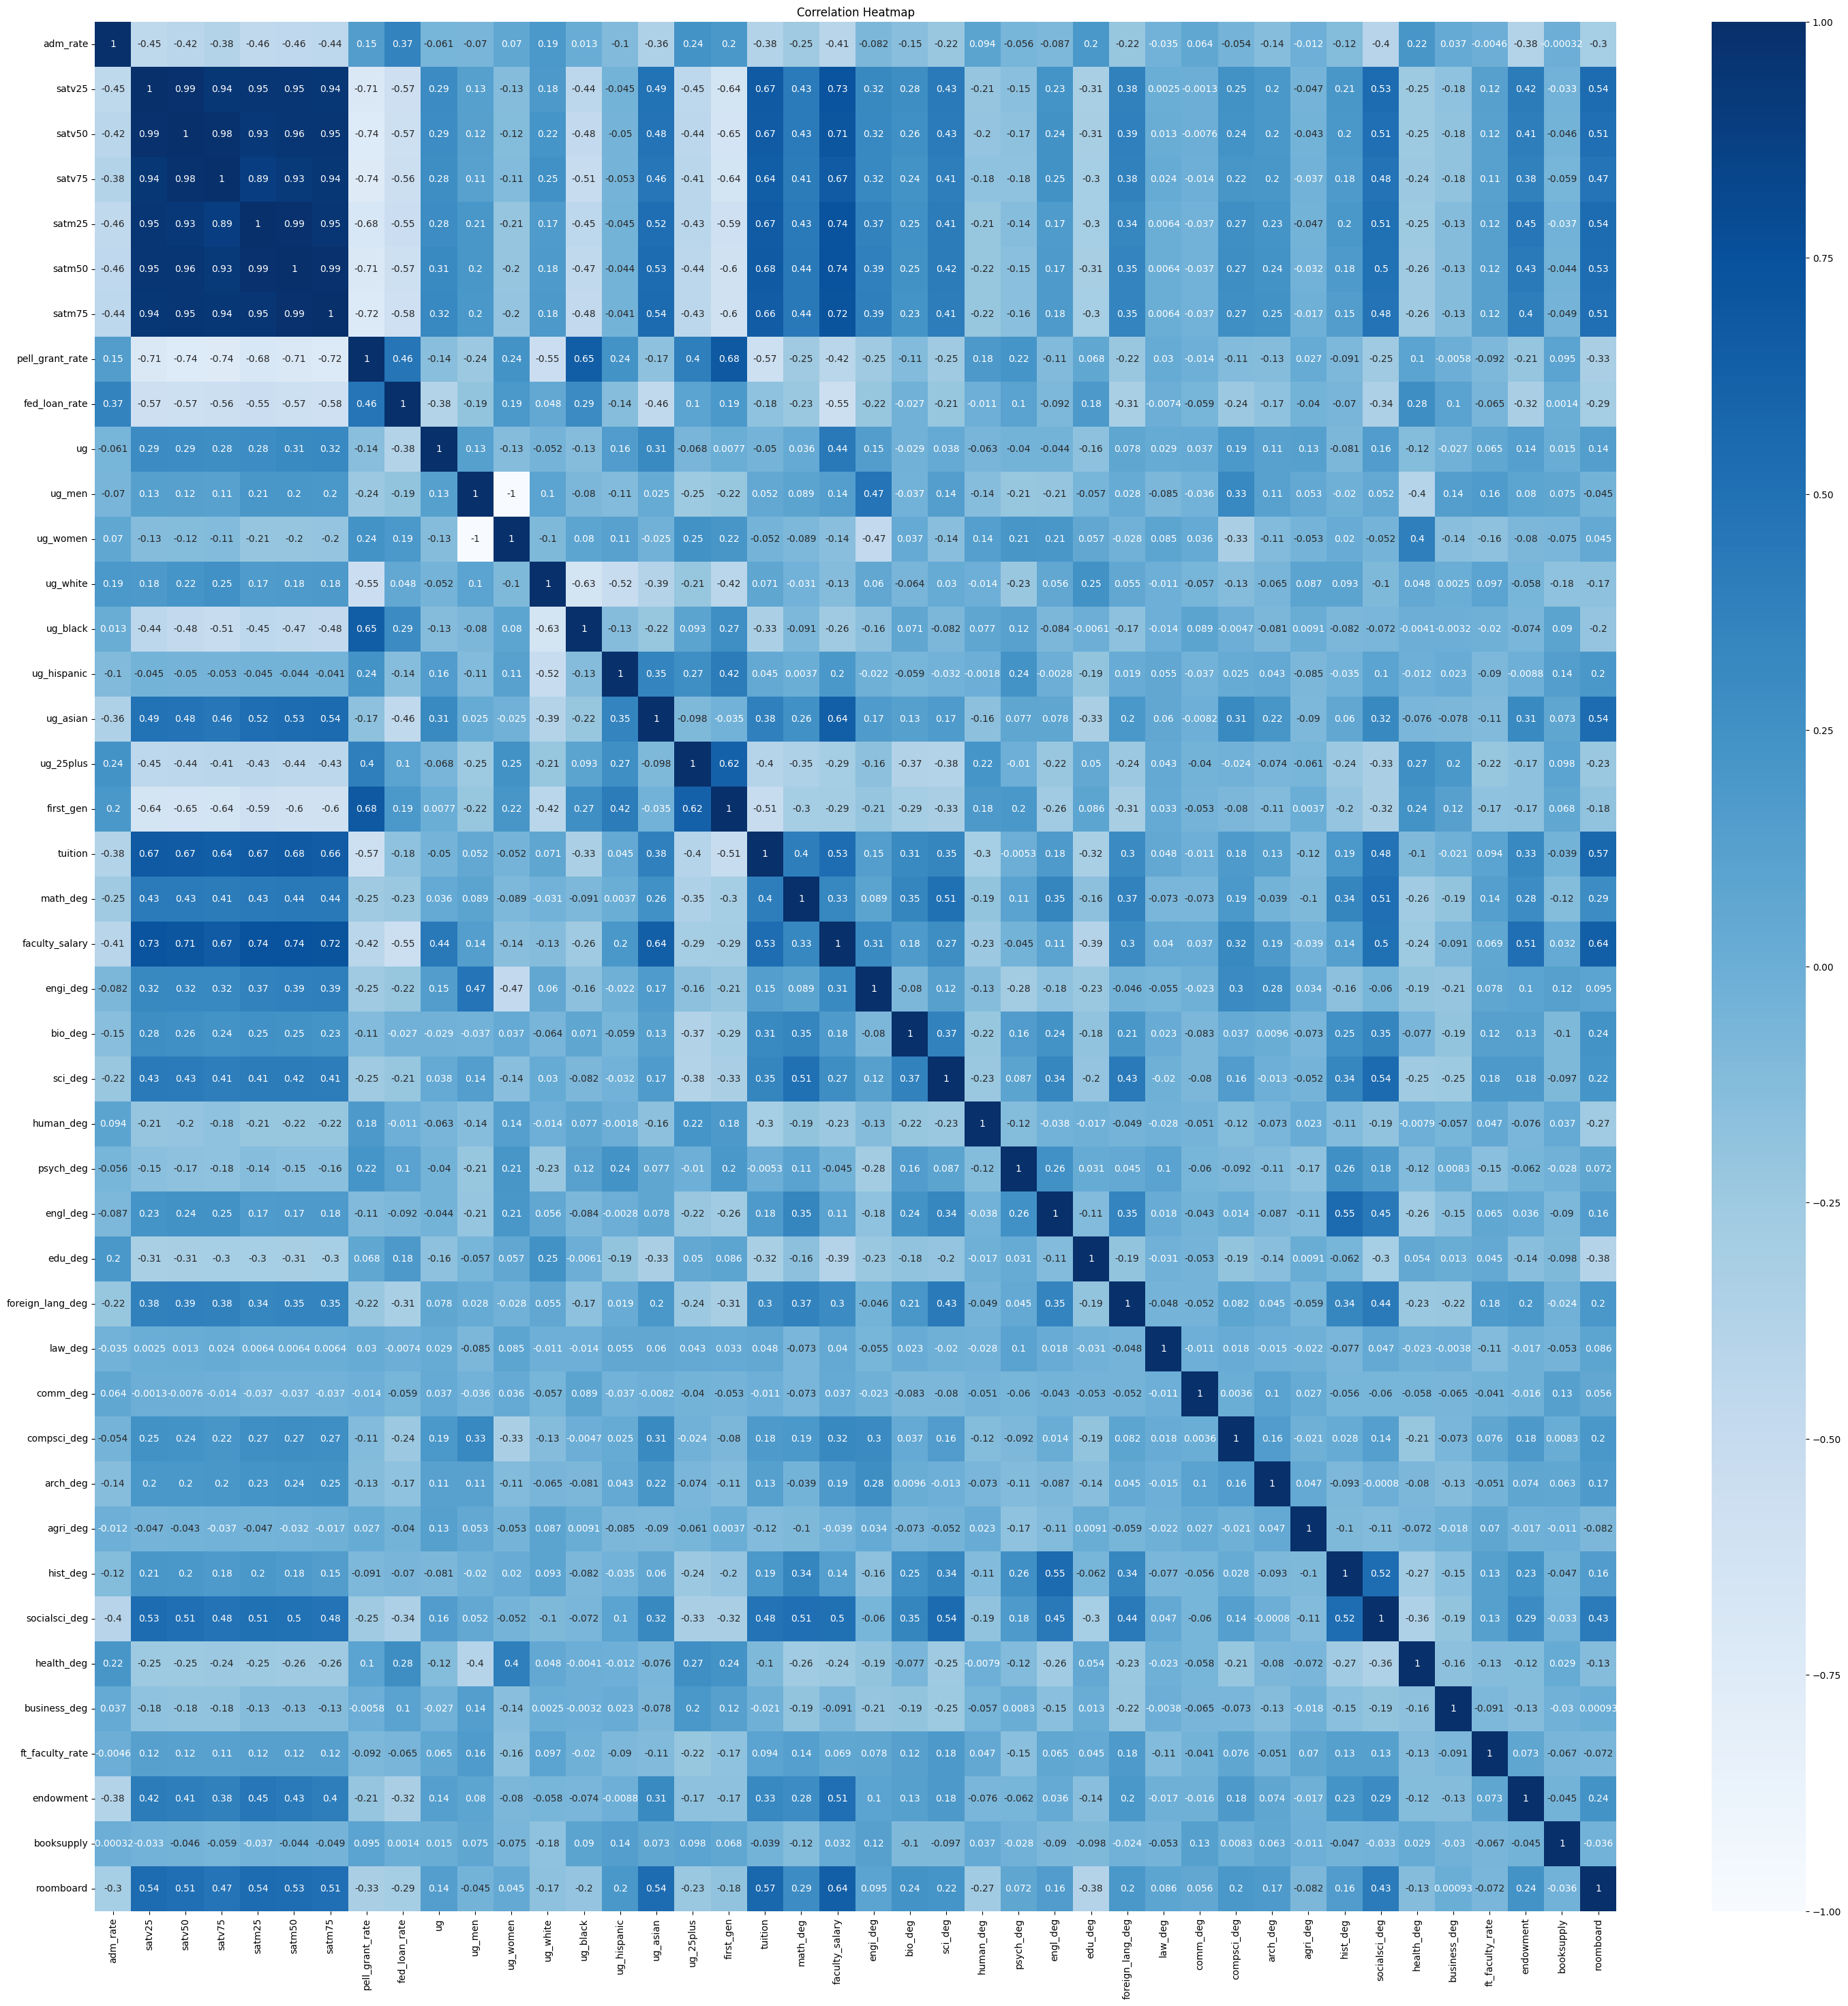

In [ ]:
# Plot correlation heatmap
correlation_matrix = df.drop(columns=['name', 'state']).corr()
plt.figure(figsize=(36, 36))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# Baseline (use mean for prediction)
y_mean = np.mean(y_train)
y_baseline = np.full_like(y_test, fill_value=y_mean)

mse_baseline = mean_squared_error(y_test, y_baseline)
print("Baseline Mean Squared Error:", mse_baseline)

Baseline Mean Squared Error: 177407043.6625


Linear Regression Mean Squared Error: 114646642.5493691


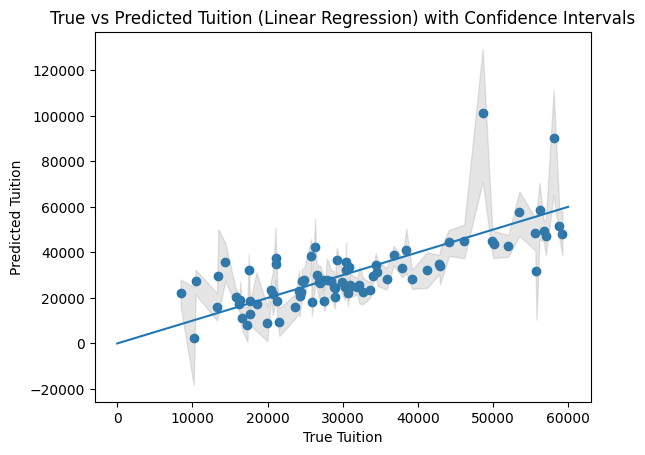

In [ ]:
# Linear Regression
def bootstrap_and_fit(X_train_scaled, y_train, X_test_scaled):
    indices = np.random.choice(len(X_train_scaled), size=len(X_train_scaled), replace=True)
    X_boot = X_train_scaled[indices]
    y_boot = y_train[indices]

    model = LinearRegression()
    model.fit(X_boot, y_boot)

    y_pred = model.predict(X_test_scaled)
    return y_pred

num_bootstraps = 100
# Create a ThreadPoolExecutor with the desired number of threads
with ThreadPoolExecutor(max_workers=None) as executor:
    # Submit tasks for each bootstrap iteration
    futures = [executor.submit(bootstrap_and_fit, X_train_scaled, y_train, X_test_scaled) for _ in range(num_bootstraps)]
    all_predictions = [future.result() for future in futures] # Gather results from completed tasks

lower_quantile = np.percentile(all_predictions, 10, axis=0)
upper_quantile = np.percentile(all_predictions, 90, axis=0)

mse = mean_squared_error(y_test, np.mean(all_predictions, axis=0))
print("Linear Regression Mean Squared Error:", mse)

sorted_indices = np.argsort(y_test)
y_test_sorted = y_test[sorted_indices]
mean_predictions_sorted = np.mean(all_predictions, axis=0)[sorted_indices]

# Plot the true vs predicted tuition with confidence intervals
plt.scatter(y_test_sorted, mean_predictions_sorted)
plt.plot([0, 60000], [0, 60000])
plt.fill_between(y_test_sorted, lower_quantile[sorted_indices], upper_quantile[sorted_indices], color='gray', alpha=0.2)
plt.xlabel('True Tuition')
plt.ylabel('Predicted Tuition')
plt.title('True vs Predicted Tuition (Linear Regression) with Confidence Intervals')
plt.show()

In [ ]:
# Define your model and other necessary components
model = LinearRegression()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
x = scaler.fit_transform(x)
y.reset_index(drop=True, inplace=True)
mse_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(x):
    X_train_cv, X_test_cv = x[train_index], x[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    # Train your model on the training data
    model.fit(X_train_cv, y_train_cv)

    # Predict on the test data
    y_pred_cv = model.predict(X_test_cv)

    # Calculate MSE and append to the list of scores
    mse = mean_squared_error(y_test_cv, y_pred_cv)
    mse_scores.append(mse)

# Calculate the mean and standard deviation of MSE scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print(f'Mean MSE: {mean_mse}')
print(f'Standard deviation of MSE: {std_mse}')

Mean MSE: 182124543.80944934
Standard deviation of MSE: 57529836.37193286


Random Forest Mean Squared Error: 33426113.17040906


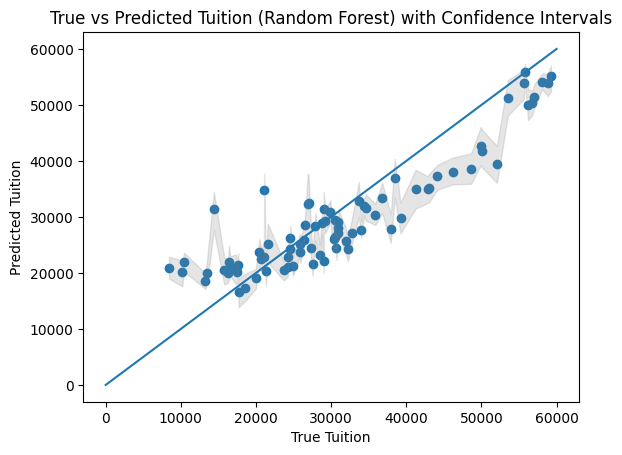

In [ ]:
# Random Forest
# Hyperparameters tested: n_estimators = 25, 35, 40, 50 (best), 100, 200
def bootstrap_and_fit(X_train_scaled, y_train, X_test_scaled):
    indices = np.random.choice(len(X_train_scaled), size=len(X_train_scaled), replace=True)
    X_boot = X_train_scaled[indices]
    y_boot = y_train[indices]

    rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
    rf_model.fit(X_boot, y_boot)

    y_pred_rf = rf_model.predict(X_test_scaled)
    return y_pred_rf

num_bootstraps = 100
# Create a ThreadPoolExecutor with the desired number of threads
with ThreadPoolExecutor(max_workers=None) as executor:
    # Submit tasks for each bootstrap iteration
    futures = [executor.submit(bootstrap_and_fit, X_train_scaled, y_train, X_test_scaled) for _ in range(num_bootstraps)]
    all_predictions_rf = [future.result() for future in futures] # Gather results from completed tasks

lower_quantile_rf = np.percentile(all_predictions_rf, 10, axis=0)
upper_quantile_rf = np.percentile(all_predictions_rf, 90, axis=0)

mse_rf = mean_squared_error(y_test, np.mean(all_predictions_rf, axis=0))
print("Random Forest Mean Squared Error:", mse_rf)

sorted_indices = np.argsort(y_test)
y_test_sorted = y_test[sorted_indices]
mean_predictions_rf_sorted = np.mean(all_predictions_rf, axis=0)[sorted_indices]
lower_quantile_rf_sorted = lower_quantile_rf[sorted_indices]
upper_quantile_rf_sorted = upper_quantile_rf[sorted_indices]

# Plot the true vs predicted tuition with confidence intervals
plt.scatter(y_test_sorted, mean_predictions_rf_sorted)
plt.plot([0, 60000], [0, 60000])
plt.fill_between(y_test_sorted, lower_quantile_rf_sorted, upper_quantile_rf_sorted, color='gray', alpha=0.2)
plt.xlabel('True Tuition')
plt.ylabel('Predicted Tuition')
plt.title('True vs Predicted Tuition (Random Forest) with Confidence Intervals')
plt.show()

In [ ]:
# Define your model and other necessary components
model = RandomForestRegressor(n_estimators=50, random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
x = scaler.fit_transform(x)
y.reset_index(drop=True, inplace=True)
mse_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(x):
    X_train_cv, X_test_cv = x[train_index], x[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    # Train your model on the training data
    model.fit(X_train_cv, y_train_cv)

    # Predict on the test data
    y_pred_cv = model.predict(X_test_cv)

    # Calculate MSE and append to the list of scores
    mse = mean_squared_error(y_test_cv, y_pred_cv)
    mse_scores.append(mse)

# Calculate the mean and standard deviation of MSE scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print(f'Mean MSE: {mean_mse}')
print(f'Standard deviation of MSE: {std_mse}')

Mean MSE: 36178817.16169201
Standard deviation of MSE: 11624711.363170123


XGBoost Mean Squared Error: 28643406.839717723


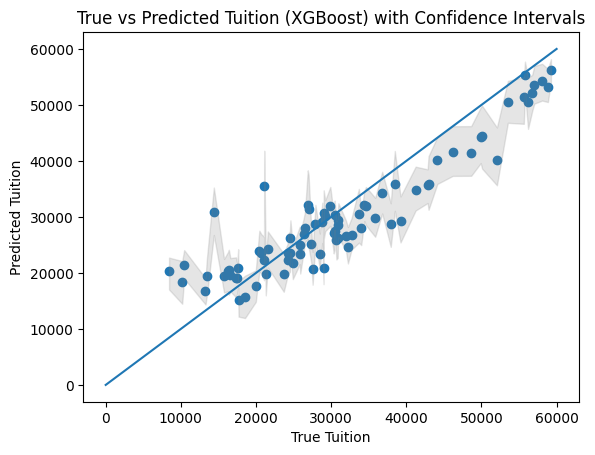

In [ ]:
# XGBoost
# Hyperparameters tested: n_estimators = 50 (best), 100
# Has better MSE but larger confidence intervals than Random Forest
def bootstrap_and_fit(X_train_scaled, y_train, X_test_scaled):
    indices = np.random.choice(len(X_train_scaled), size=len(X_train_scaled), replace=True)
    X_boot = X_train_scaled[indices]
    y_boot = y_train[indices]

    xgb_model = xgb.XGBRegressor(n_estimators=50, max_depth=3, random_state=42)
    xgb_model.fit(X_boot, y_boot)

    y_pred_rf = xgb_model.predict(X_test_scaled)
    return y_pred_rf

num_bootstraps = 100
# Create a ThreadPoolExecutor with the desired number of threads
with ThreadPoolExecutor(max_workers=None) as executor:
    # Submit tasks for each bootstrap iteration
    futures = [executor.submit(bootstrap_and_fit, X_train_scaled, y_train, X_test_scaled) for _ in range(num_bootstraps)]
    all_predictions_xgb = [future.result() for future in futures] # Gather results from completed tasks

lower_quantile_xgb = np.percentile(all_predictions_xgb, 10, axis=0)
upper_quantile_xgb = np.percentile(all_predictions_xgb, 90, axis=0)

mse_rf = mean_squared_error(y_test, np.mean(all_predictions_xgb, axis=0))
print("XGBoost Mean Squared Error:", mse_rf)

sorted_indices = np.argsort(y_test)
y_test_sorted = y_test[sorted_indices]
mean_predictions_xgb_sorted = np.mean(all_predictions_xgb, axis=0)[sorted_indices]
lower_quantile_xgb_sorted = lower_quantile_xgb[sorted_indices]
upper_quantile_xgb_sorted = upper_quantile_xgb[sorted_indices]

# Plot the true vs predicted tuition with confidence intervals
plt.scatter(y_test_sorted, mean_predictions_xgb_sorted)
plt.plot([0, 60000], [0, 60000])
plt.fill_between(y_test_sorted, lower_quantile_xgb_sorted, upper_quantile_xgb_sorted, color='gray', alpha=0.2)
plt.xlabel('True Tuition')
plt.ylabel('Predicted Tuition')
plt.title('True vs Predicted Tuition (XGBoost) with Confidence Intervals')
plt.show()

In [ ]:
# Define your model and other necessary components
model = xgb.XGBRegressor(n_estimators=50, max_depth=3, random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
x = scaler.fit_transform(x)
y.reset_index(drop=True, inplace=True)
mse_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(x):
    X_train_cv, X_test_cv = x[train_index], x[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    # Train your model on the training data
    model.fit(X_train_cv, y_train_cv)

    # Predict on the test data
    y_pred_cv = model.predict(X_test_cv)

    # Calculate MSE and append to the list of scores
    mse = mean_squared_error(y_test_cv, y_pred_cv)
    mse_scores.append(mse)

# Calculate the mean and standard deviation of MSE scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print(f'Mean MSE: {mean_mse}')
print(f'Standard deviation of MSE: {std_mse}')

Mean MSE: 36217509.85288279
Standard deviation of MSE: 10662675.914741682


Neural Network Mean Squared Error: 91582699.8671623


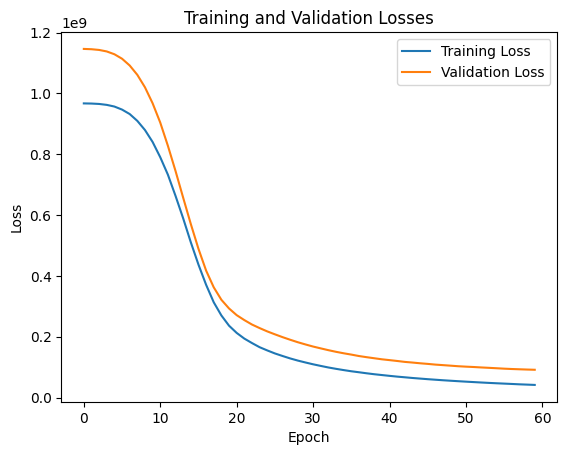

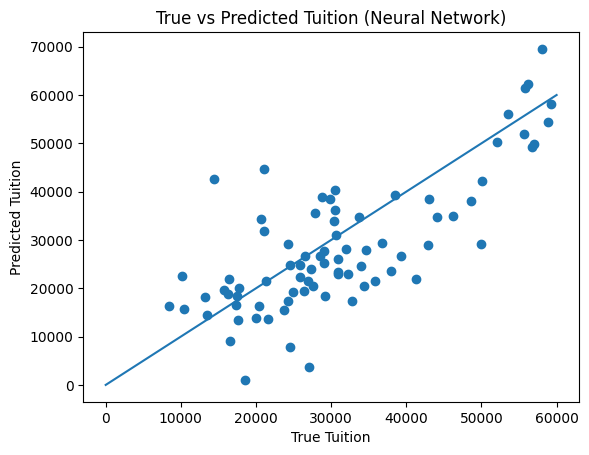

In [ ]:
# Neural Network
# Hyperparameters tested: 1 hidden layer (hidden_dim = 64), 2 hidden layers (hidden_dim = 128, 64), 3 hidden layers (hidden_dim = 256, 128, 64)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Define the neural network
class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

net = Net(input_dim=X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_losses = []
val_losses = []
for epoch in range(60):
    # Training phase
    net.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    net.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = net(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

y_pred_nn = net(X_test_tensor).detach().numpy()
mse_nn = mean_squared_error(y_test, y_pred_nn)
print("Neural Network Mean Squared Error:", mse_nn)

# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Plot the true vs predicted tuition
plt.scatter(y_test, y_pred_nn)
plt.plot([0, 60000], [0, 60000])
plt.xlabel('True Tuition')
plt.ylabel('Predicted Tuition')
plt.title('True vs Predicted Tuition (Neural Network)')
plt.show()

In [ ]:
####### Run cell #2 (preprocessing training data) again before running this cell #######

# Final Model: XGBoost
# Read and preprocess test data
test_data = pd.read_csv('colleges_test_features.csv')
test_data = test_data.drop(columns=['state'])
test_columns = test_data.columns
for comb in itertools.combinations(test_columns, 2):
    test_data[comb[0] + '*' + comb[1]] = test_data[comb[0]] * test_data[comb[1]]
    test_data[comb[0] + '/' + comb[1]] = np.where(test_data[comb[1]] != 0, test_data[comb[0]] / test_data[comb[1]], 0)
scaled_test_data = scaler.transform(test_data)

# Combine training and testing data from the original dataset
combined_x = np.concatenate((X_train_scaled, X_test_scaled), axis=0)
combined_y = np.concatenate((y_train, y_test), axis=0)

# Define a function for bootstrapping and model fitting
def bootstrap_and_fit(combined_x, combined_y, scaled_test_data):
    indices = np.random.choice(len(combined_x), size=len(combined_x), replace=True)
    X_boot = combined_x[indices]
    y_boot = combined_y[indices]

    xgb_model = xgb.XGBRegressor(n_estimators=50, max_depth=3, random_state=42)
    xgb_model.fit(X_boot, y_boot)

    y_pred_xgb = xgb_model.predict(scaled_test_data)
    return y_pred_xgb

num_bootstraps = 1000
# Create a ThreadPoolExecutor with the desired number of threads
with ThreadPoolExecutor(max_workers=None) as executor:
    # Submit tasks for each bootstrap iteration
    futures = [executor.submit(bootstrap_and_fit, combined_x, combined_y, scaled_test_data) for _ in range(num_bootstraps)]
    all_predictions_xgb = [future.result() for future in futures] # Gather results from completed tasks

lower_quantile_xgb = np.percentile(all_predictions_xgb, 10, axis=0)
upper_quantile_xgb = np.percentile(all_predictions_xgb, 90, axis=0)

# Save predictions to a CSV file
predictions = pd.DataFrame({'pred': np.mean(all_predictions_xgb, axis=0), 'lower': lower_quantile_xgb, 'upper': upper_quantile_xgb})
predictions.to_csv('predictions.csv', index=False)